## Setup

### Package Import

In [24]:
# Install external packages for Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install rasterfairy-py3 spotipy umap-learn -q

In [25]:
# Import packages
from getpass import getpass        # secure text entry
from io import BytesIO             # reading binary data
from IPython.display \
  import clear_output              # clearing cell output
import numpy as np                 # mathematics
import os                          # setting environment variables
import pandas as pd                # storing audio features as dataframe
from PIL import Image              # image export
import plotly.express as px        # basic interactive visualisation
import plotly.graph_objects as go  # advanced plotting functionality
import rasterfairy                 # rasterfying point clouds
import requests                    # web requests
from sklearn.preprocessing \
  import StandardScaler            # feature standardisation
import spotipy                     # Python interface to Spotify API
import umap                        # dimensionality reduction

### Parameters

In [26]:
# Parameters
# NB: Use 'vr1q8on6ji60ceo0kregujkkx' for playlists from WDSS
USERNAME = 'vr1q8on6ji60ceo0kregujkkx'  # user to extract public playlists from
RESOLUTION = 2  # 0 (extreme); 1 (high); 2 (low)
ORIENTATION = 'landscape'  # landscape; portrait
MIN_RATIO = 0.5  # minimum ratio between shortest and longest dimension

### Helper Functions

In [27]:
# Define helper functions
def depaginate(first_page):
  """
  Flatten the paginated response from the Spotify API.
  
  The Spotify API returns responses over a certain size using pagination (like
  how Google has multiple page of results). This function takes the first page
  of a response and uses this to run through all other pages and return the
  page items in a flattened format.
  """
  page = first_page
  while page:
    for item in page['items']:
      yield item
    page = sp.next(page)

def resolution_map(resolution):
  """Return the pixel value corresponding to different resolution levels."""
  return [600, 300, 64][resolution]

def mel_to_harm(key):
  """Convert absolute keys to positions relative to the circle of fifths."""
  return (key * 7) % 12

def create_hover_text(track_df, features=None):
  """
  Create hover text for plots.
  
  Omit the second argument to leave out extra hover text for audio features.
  """
  text = (
      "Name: " + track_df['name'] + "<br>" +
      "Artist: " + track_df['artist'] + "<br>" +
      "Album: " + track_df['album'] + "<br><extra>"
  )
  if features:
    for f in features:
      text = text + f + ": " + track_df[f].apply(str) + "<br>"
  return text + "</extra>"

def find_valid_sample_count(track_df, min_ratio):
  """
  Find a sample count that can form a rectangle satisfying a minimum ratio.

  For difficult numbers of observations (e.g. a prime), only long rectangles
  can be formed in the final visualisation. We therefore keep decreasing the
  number of points until we have form a rectangle that satisfies a minimum
  ratio between side lengths.
  """
  n = len(track_df)
  found_solution = False
  while not found_solution:
    i, j = rasterfairy.getRectArrangements(n)[0]
    if i / j >= MIN_RATIO:
      found_solution = True
    else:
      n -= 1
  return n

### API Connection

In [28]:
# Authentication environment variables
overwrite_existing = False  # set to True to overwrite existing values
if overwrite_existing or 'SPOTIPY_CLIENT_ID' not in os.environ \
    or 'SPOTIPY_CLIENT_SECRET' not in os.environ:
  os.environ['SPOTIPY_CLIENT_ID'] = getpass("What is your client ID?\n")
  os.environ['SPOTIPY_CLIENT_SECRET'] = getpass("What is your client secret?\n")

In [29]:
# Initialise client
auth_manager = spotipy.SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

## Data Scraping

### Collect Playlists

In [30]:
# Create list to store key playlist information
playlist_info = []

# Loop through all playlists
for playlist in depaginate(sp.user_playlists(USERNAME)):
  # Add playlist information to list
  playlist_info.append({
      'name': playlist['name'],
      'size': playlist['tracks']['total'],
      'id': playlist['id'],
  })

In [31]:
# Display playlist choices
max_digits = len(str(len(playlist_info)))
for i, info in enumerate(playlist_info):
  print(f"({str(i).zfill(max_digits)}) {info['name']} [{info['size']} tracks]")

(0) Exec Playlist [289 tracks]
(1) Polarised [64 tracks]


### Playlist Selection

In [47]:
# Get user to select a playlist
valid = False  # placeholder to start off loop

while not valid:
  # Ask user for input
  choice_idx = input("Select a playlist index from the list above:\n")
  # Check if the input was valid
  valid = choice_idx.isnumeric() and 0 <= int(choice_idx) < len(playlist_info)
  if not valid:
    clear_output(wait=True)
    print(f"Selection must be an integer between 0 and {len(playlist_info)-1}")

# Python returns input as text so convert to an integer
choice_idx = int(choice_idx)
print(f"\nYou selected '{playlist_info[choice_idx]['name']}'")

Select a playlist index from the list above:
 0



You selected 'Exec Playlist'


### Collect Tracks Details

In [48]:
# Get the ID of the choosen playlist
choice_id = playlist_info[choice_idx]['id']
# Create list to store key playlist information
track_info = []

# Loop through all playlist items
for item in depaginate(sp.playlist_items(choice_id)):
  # Extract track information, ignoring item metadata (e.g. date added)
  track = item['track']
  track_info.append({
      'name': track['name'],
      'artist': track['artists'][0]['name'],
      'album': track['album']['name'],
      # NB: some tracks are missing artworks for all/some resolutions. If this
      # is an issue, the simplest solution is to remove them from the playlist
      'art_url': track['album']['images'][RESOLUTION]['url'],
      'id': track['id'],
  })

### Collect Audio Features

In [49]:
# List features to collect. See: https://spoti.fi/2Rhrtye
included = (
    'duration_ms', 'key', 'mode', 'time_signature',
    'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
    'loudness', 'speechiness', 'valence', 'tempo', 
)

# Audio feature requests have to be performed in batches of at most 100 IDs
for offset in range(0, len(track_info), 100):
  # Collect all features
  features = sp.audio_features(t['id'] for t in track_info[offset:offset+100])
  # Filter to only include the features listed above
  features = [{k: v for k, v in t.items() if k in included} for t in features]
  # Add features to track info
  for i in range(min(100, len(track_info) - offset)):
    track_info[i + offset].update(features[i])

In [50]:
# Convert to dataframe
track_df = pd.DataFrame(track_info)

## Pre-processing

### Sampling

In [51]:
# Find a sample count that satisfies the minimum ratio
n = find_valid_sample_count(track_df, MIN_RATIO)

# Take random sample of chosen size
print(f"Randomly removing {len(track_df) - n} tracks to leave {n} remaining")
sampled_track_df = track_df.sample(n, random_state=1729).reset_index(drop=True)

Randomly removing 0 tracks to leave 289 remaining


In [52]:
# Extract feature columns into own dataframe
features_df = sampled_track_df.drop(
    ['name', 'artist', 'album', 'art_url', 'id'], axis=1
)

### Feature Engineering

In [53]:
# Transform key from polar coordinates using melodic distance
features_df['key_melodic_x'] = np.cos(features_df['key'] / 6 * np.pi)
features_df['key_melodic_y'] = np.sin(features_df['key'] / 6 * np.pi)

# Transform key from polar coordinates using harmonic distance
features_df['key_harmonic'] = features_df['key'].apply(mel_to_harm)
features_df['key_harmonic_x'] = np.cos(features_df['key_harmonic'] / 6 * np.pi)
features_df['key_harmonic_y'] = np.sin(features_df['key_harmonic'] / 6 * np.pi)

# Remove redundant columns
features_df.drop(['key', 'key_harmonic'], axis=1, inplace=True)

# Handle missing keys
features_df.iloc[:,-4:].fillna(0, inplace=True)

### Standardisation

In [54]:
scaled_features = StandardScaler().fit_transform(features_df)

# Two features represent the key so weight these a factor of one half
scaled_features[:,-4:] /= 2

## Dimensionality Reduction

### Embedding

In [55]:
# Embedded the audio features into two dimensions
embedding = umap.UMAP(
    n_components=2,
    # Embedding hyperparameters used to balance local and global structure
    # See:
    #   https://pair-code.github.io/understanding-umap/
    #   https://umap-learn.readthedocs.io/en/latest/parameters.html
    n_neighbors=10,
    min_dist=0.5,
    metric='euclidean',
    # Random seed used for reproducibility
    random_state=1729).fit_transform(scaled_features)

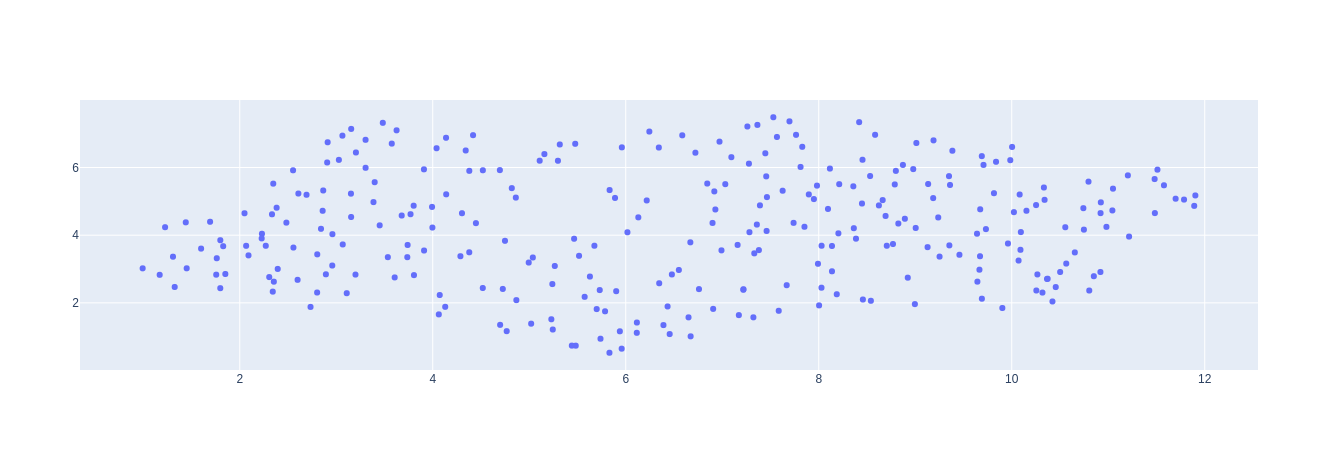

In [56]:
# View embedding
x = embedding[:, 0]
y = embedding[:, 1]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y,
    hovertemplate = '%{text}',
    # Add `included` as a second argument to show audio features on hover
    text=create_hover_text(sampled_track_df)
))

fig.update_traces(mode='markers')

fig.show()

### Rasterfication

In [57]:
# Rasterfy embedding
grid, dims = rasterfairy.transformPointCloud2D(
    embedding[:, :], proportionThreshold=MIN_RATIO
)

# Fix grid type
grid = grid.astype(int)

# Fix orientation (portrait by default)
if ORIENTATION == 'portrait':
   pass
elif ORIENTATION == 'landscape':
  grid = grid[:, ::-1]
  dims = dims[::-1]
else:
  raise ValueError("invalid orientation")

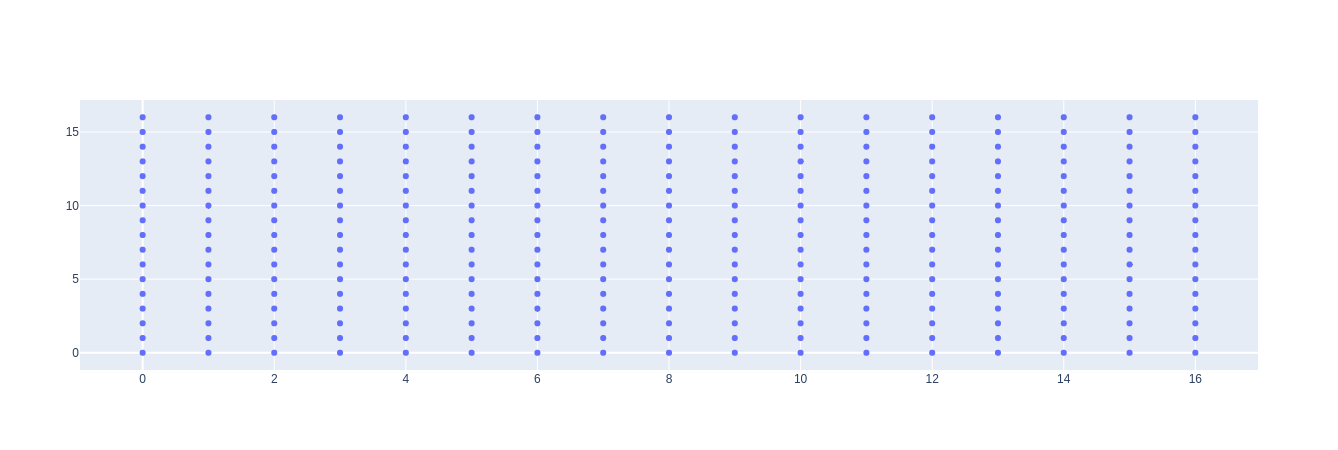

In [58]:
# View rasterfied embedding
x = grid[:, 0]
y = grid[:, 1]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y,
    hovertemplate = '%{text}',
    # Add `included` as a second argument to show audio features on hover
    text=create_hover_text(sampled_track_df)
))

fig.update_traces(mode='markers')

fig.show()

## Visualisation

### Create Image

In [59]:
# Covert resolution level to number of pixels
px = resolution_map(RESOLUTION)
width = px * dims[0]
height = px * dims[1]

# Create empty grid to store cover art
art_grid = np.empty((height, width, 3))

for i, row in sampled_track_df.iterrows():
  res = requests.get(row['art_url'])
  img = Image.open(BytesIO(res.content))
  img = img.resize((px, px), Image.ANTIALIAS).convert('RGB')
  art_grid[px * grid[i, 1]:px * (grid[i, 1] + 1),
           px * grid[i, 0]:px * (grid[i, 0] + 1)] = np.array(img)

In [63]:
sp.categories(country='GB', limit=3)

{'categories': {'href': 'https://api.spotify.com/v1/browse/categories?country=GB&offset=0&limit=3',
  'items': [{'href': 'https://api.spotify.com/v1/browse/categories/toplists',
    'icons': [{'height': 275,
      'url': 'https://t.scdn.co/media/derived/toplists_11160599e6a04ac5d6f2757f5511778f_0_0_275_275.jpg',
      'width': 275}],
    'id': 'toplists',
    'name': 'Top Lists'},
   {'href': 'https://api.spotify.com/v1/browse/categories/pop',
    'icons': [{'height': 274,
      'url': 'https://t.scdn.co/media/derived/pop-274x274_447148649685019f5e2a03a39e78ba52_0_0_274_274.jpg',
      'width': 274}],
    'id': 'pop',
    'name': 'Pop'},
   {'href': 'https://api.spotify.com/v1/browse/categories/hiphop',
    'icons': [{'height': 274,
      'url': 'https://t.scdn.co/media/original/hip-274_0a661854d61e29eace5fe63f73495e68_274x274.jpg',
      'width': 274}],
    'id': 'hiphop',
    'name': 'Hip Hop'}],
  'limit': 3,
  'next': 'https://api.spotify.com/v1/browse/categories?country=GB&offset=

### Interactive Visualisation


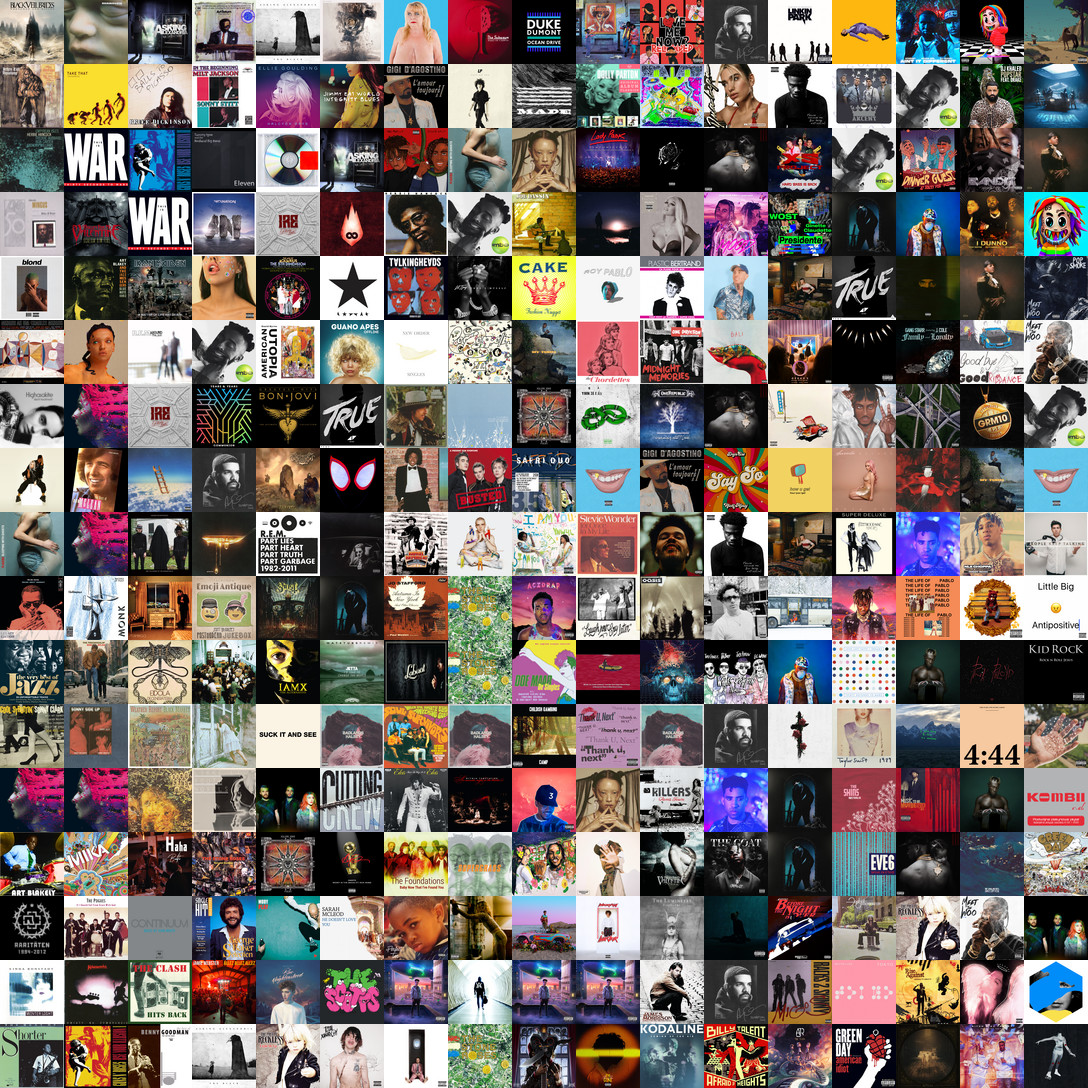

In [60]:
fig = go.Figure()

# Add invisible markers in the corners to help with autoscaling
fig.add_trace(go.Scatter(
    x=[0, width], y=[0, height],
    mode='markers', marker_opacity=0
))

# Add background image
fig.add_layout_image({
        'x': 0, 'sizex': width, 'xref': 'x',
        'y': height, 'sizey': height, 'yref': 'y',
        'opacity': 1.0, 'layer': 'below', 'sizing': 'stretch',
        # Images are plotted downwards so reverse first axis
        'source': Image.fromarray(art_grid.astype(np.uint8))
})

# Add labels through an invisible heatmap
x = [px // 2 + px * i for i in range(dims[0])]
y = [px // 2 + px * j for j in range(dims[1])]
# Add `included` as a second argument to show audio features on hover
hover_text = create_hover_text(sampled_track_df)
labels = np.empty(dims[::-1], dtype='object')
for i in range(len(sampled_track_df)):
    labels[dims[1] - 1 - grid[i, 1], grid[i, 0]] = hover_text[i]
z = np.random.uniform(size=dims[::-1])  # random values for invisible heatmap

fig.add_trace(go.Heatmap(
    x=x, y=y, z=z, hovertemplate = '%{text}', text=labels,
    opacity=0, showscale=False
))

fig.update_xaxes(
    visible=False,
    range=[0, width]
)
fig.update_yaxes(
    visible=False,
    range=[0, height],
    # Fix aspect ratio
    scaleanchor='x'
)

fig.update_layout(
    width=width,
    height=height,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
    plot_bgcolor='black'
)

# Disable the autosize on double click because it adds unwanted margins
fig.show(config={'doubleClick': 'reset'})

### Image Export

In [61]:
# Save image to files - download from the sidebar
Image.fromarray(art_grid.astype(np.uint8)).save('wall_of_music.png')